# spaOTsc Analysis: Domain Prediction

## Xenium Breast Cancer, InSitu Replicate 1

https://www.10xgenomics.com/products/xenium-in-situ/human-breast-dataset-explorer



### 1. Import packages

In [2]:
# imports
import novosparc as ns

import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scanpy import read_10x_h5
from matplotlib.pyplot import figure
import random
random.seed(0)

In [3]:
import cv2 as cv
from skimage import io, color
import torch
from torch.nn import functional as F
import json

In [4]:
import os,csv,re
import math
from skimage import io, color

from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import pickle
from sklearn.model_selection import train_test_split
from anndata import AnnData, read_h5ad
import seaborn as sns

import dit
from dit import pid
import sys
sys.path.append('/Users/ameliaschroeder/CeLEry/CeLEry_package')

import CeLEry as cel

In [5]:
from spaotsc import SpaOTsc

### 2. Load data



In [8]:
# cells to be filtered out based on total UMI and number of genes expressed
os.chdir("")
lowUMI_cellID = pd.read_csv("cell_ID_toRemove_filtered_25_25.csv",sep=",",na_filter=False,index_col=0)

In [9]:
#Read in gene expression and spatial location
os.chdir("")
adata = read_10x_h5("Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5")
spatial_full = pd.read_csv("Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv",sep=",",na_filter=False,index_col=0)

In [63]:
os.chdir("")
kmeans10_clustering = pd.read_csv("clusters.csv", index_col=0)
kmeans10_clustering

,Cluster
Barcode,
1,5
2,8
3,4
4,1
5,4
...,...
167778,2
167779,2
167780,2


In [10]:
os.chdir("")
train_index = pd.read_csv("trainCell_index.csv",sep=",")
test_index = pd.read_csv("testCell_index.csv",sep=",")

train_index = list(train_index.iloc[:,1])
test_index = list(test_index.iloc[:,1])

In [13]:
spatial_full

,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area
cell_id,,,,,,,,
1,377.663005,843.541888,154,0,0,154,110.361875,45.562656
2,382.078658,858.944818,64,0,0,64,87.919219,24.248906
3,319.839529,869.196542,57,0,0,57,52.561875,23.526406
4,259.304707,851.797949,120,0,0,120,75.230312,35.176719
5,370.576291,865.193024,120,0,0,120,180.218594,34.499375
...,...,...,...,...,...,...,...,...
167778,7455.404785,5115.021094,238,1,0,239,219.956094,61.412500
167779,7483.771045,5111.720703,80,0,0,80,38.427969,25.964844
167780,7470.119580,5119.350366,406,0,0,406,287.690469,86.158125


In [14]:
# The pixel size of Xenium 0.2125 microns. 
# Coordinates in microns from cells.csv.gz can be converted to pixel coordinates 
# by dividing by the pixel size. The origin of the coordinate system is the upper left of the TIFF image.


pixel_size = 0.2125

spatial = pd.DataFrame()
spatial['0'] = spatial_full.x_centroid
spatial['1'] = [1] * 167782
spatial['2'] = spatial_full.x_centroid
spatial['3'] = spatial_full.y_centroid 
spatial['4'] = spatial_full.x_centroid / pixel_size
spatial['5'] = spatial_full.y_centroid / pixel_size

b = ['CellID '] * 167782
a = list(range(1,167783))

#spatial.index = [m+str(n) for m,n in zip(b,a)]

spatial.index = spatial.index.astype('str')


spatial = spatial.drop(['0'], axis = 1)
spatial.index.name = '0'
spatial.columns = spatial.columns.astype('int64')

spatial = spatial.astype('int64')
adata.obs_names = spatial.index.astype('str')


In [21]:
TrainDatafull = cel.make_annData_spatial(adata.copy(), spatial, filtered = True)
TrainDatafull.var['genename'] = TrainDatafull.var.gene_ids
TrainDatafull

AnnData object with n_obs × n_vars = 166313 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

### 3. Filter out cells with low UMI and low number of genes expressed


In [24]:
os.chdir("")
TrainDatafull.obs_names = TrainDatafull.obs_names.astype(np.int64) 

TrainDatafull_filtered = TrainDatafull.copy()[~TrainDatafull.obs_names.isin(lowUMI_cellID.x), :]
TrainDatafull_filtered


View of AnnData object with n_obs × n_vars = 121277 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [25]:
# double checking filtering criteria 
x = TrainDatafull_filtered.X.sum(axis=1)
y = np.sum(TrainDatafull_filtered.X>0, axis=1)

print(pd.DataFrame(x).describe())
print(pd.DataFrame(y).describe())

                   0
count  121277.000000
mean       73.582451
std         6.415282
min        52.803246
25%        68.909004
50%        73.022537
75%        77.738258
max       100.629524
                   0
count  121277.000000
mean       74.671479
std        17.577727
min        48.000000
25%        61.000000
50%        72.000000
75%        85.000000
max       197.000000


In [26]:
cel.get_zscore(TrainDatafull_filtered)

In [27]:
TrainDatafull_filtered

View of AnnData object with n_obs × n_vars = 121277 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [28]:
### Spliting into training and testing data for prediction/evalutaiton:

# making sure to use same sets across all methods

train_index = np.array(train_index).astype('str')
test_index = np.array(test_index).astype('str')

# 90% train
DataSubtrain90_coor = TrainDatafull_filtered[train_index,]

# 10% holdoff
DataSubtest10_coor = TrainDatafull_filtered[test_index,]


In [29]:
DataSubtrain90_coor

View of AnnData object with n_obs × n_vars = 60638 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [30]:
DataSubtest10_coor

View of AnnData object with n_obs × n_vars = 60639 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [31]:
holdoff = 10
dataSection1 = DataSubtrain90_coor 
dataSection2 = DataSubtest10_coor

In [33]:
dataSection1.obs['x'] = dataSection1.obs['x_cord']
dataSection1.obs['y'] = dataSection1.obs['y_cord']

dataSection2.obs['x'] = dataSection2.obs['x_cord']
dataSection2.obs['y'] = dataSection2.obs['y_cord']

In [34]:
dataSection1.X = dataSection1.X.toarray()
dataSection2.X = dataSection2.X.toarray()

In [35]:
dataSection1

AnnData object with n_obs × n_vars = 60638 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts', 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [36]:
dataSection2

AnnData object with n_obs × n_vars = 60639 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts', 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [37]:
# remove extra data stored 

del adata
del TrainDatafull_filtered
del TrainDatafull


In [38]:
import random

random.seed(2021)
torch.manual_seed(2021)
np.random.seed(2021)

#subset to only 40,000 cells so that spaOTsc method can run properly
ind = random.sample(range(0,60638), 20000)
ind2 = random.sample(range(0,60639), 20000)

print(len(ind))
print(len(ind2))

datatrain = dataSection1[ind]
datatest = dataSection2[ind2]
genes = dataSection1.var.index


20000
20000


In [39]:
datatrain

View of AnnData object with n_obs × n_vars = 20000 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts', 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [40]:
datatest

View of AnnData object with n_obs × n_vars = 20000 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts', 'x', 'y'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

## Running spaOTsc

In [41]:
random.seed(2021)
torch.manual_seed(2021)
np.random.seed(2021)

os.chdir("")

## Running spaOTsc
df_sc = pd.DataFrame(datatest.X)
is_dmat = cdist(datatrain.obs.to_numpy()[:,0:2], datatrain.obs.to_numpy()[:,0:2], 'minkowski', p=2.)
sc_dmat = cdist(datatest.X, datatest.X, 'minkowski', p=2.)
is_dmat = cdist(np.array(datatrain.obs.iloc[:,0:2]), np.array(datatrain.obs.iloc[:,0:2]), 'euclidean')
sc_dmat = cdist(datatest.X, datatest.X, 'euclidean')


In [42]:
spsc = SpaOTsc.spatial_sc(sc_data=df_sc, is_dmat=is_dmat, sc_dmat=sc_dmat)


In [43]:
cost_matrix = cdist(datatest.X, datatrain.X, 'euclidean')    

In [44]:
location_pred = spsc.transport_plan(cost_matrix)

In [45]:
location_pred_df = pd.DataFrame(location_pred)
location_pred_df.to_csv("location_pred_probs.csv", sep=',')



## Domain Prediction

In [64]:
datatrain_clust = datatrain.copy()
datatest_clust = datatest.copy()

In [65]:
barcodes = (kmeans10_clustering.index-1).astype(str)
datatrain_clust2 = datatrain_clust.copy()[datatrain_clust.obs_names.isin(list(barcodes)), :]
datatrain_clust2.obs['clusters'] = kmeans10_clustering['Cluster'][datatrain_clust2.obs_names.astype('int64')].values.astype('str')

datatrain_clust2


AnnData object with n_obs × n_vars = 19995 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts', 'x', 'y', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [66]:
barcodes = (kmeans10_clustering.index-1).astype(str)
datatest_clust2 = datatest_clust.copy()[datatest_clust.obs_names.isin(list(barcodes)), :]
datatest_clust2.obs['clusters'] = kmeans10_clustering['Cluster'][datatest_clust2.obs_names.astype('int64')].values.astype(str)

datatest_clust2


AnnData object with n_obs × n_vars = 19998 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts', 'x', 'y', 'x_pred', 'y_pred', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [68]:
location_pred_dom = location_pred.copy()
location_pred_dom = location_pred_dom[:,datatrain_clust.obs_names.isin(list(barcodes))]

location_pred_dom.shape


(20000, 19995)

In [69]:
## cell type prediction
type_pred = []
for i in range(location_pred.shape[0]):
    bestindex = np.argmax(location_pred_dom[i,:])
    
    # best.append(bestindex)
    type_pred.append(datatrain_clust2.obs['clusters'][bestindex])

In [70]:
type_pred = np.array(type_pred)
type_pred_final = type_pred[datatest_clust.obs_names.isin(list(barcodes))]
np.sum(type_pred_final == datatest_clust2.obs['clusters'])/len(type_pred_final)

0.8513351335133513

In [71]:
datatest_clust2.obs['pred_layer'] = type_pred_final

In [72]:
order = ['1', '2', '3', '5', '4', '6', '7', '8', '9', '10']


## True 

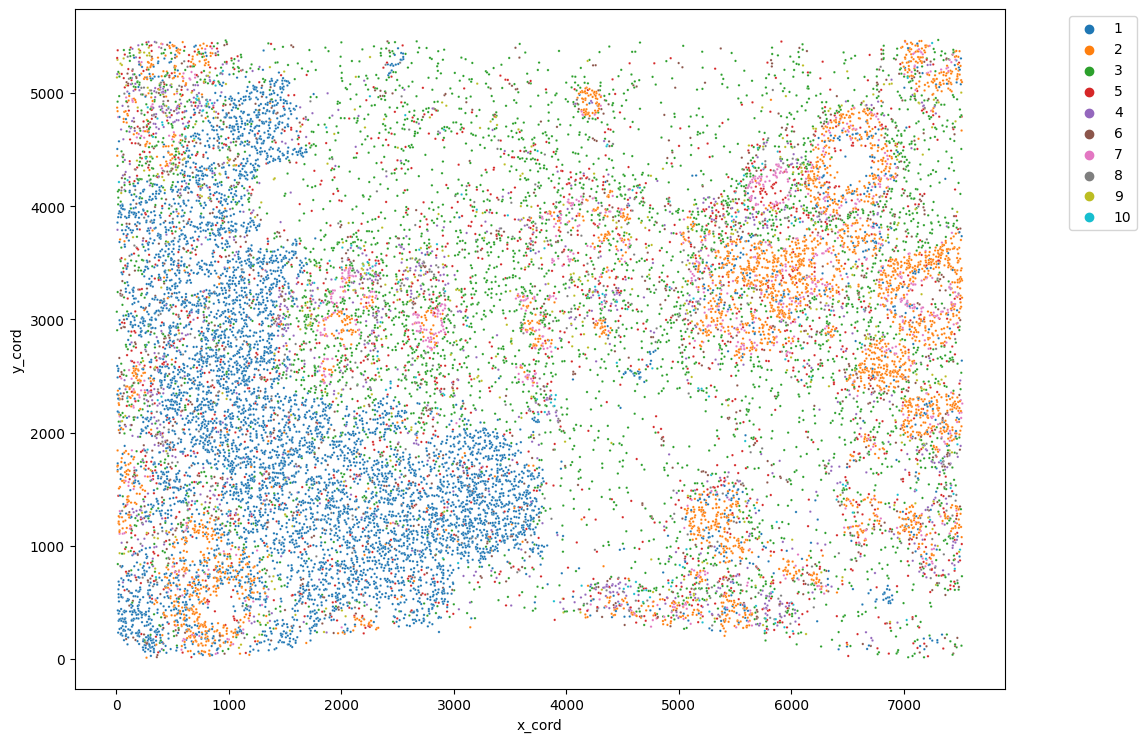

In [80]:
figure(figsize=(12, 9), dpi=100)

sns.scatterplot(data=datatest_clust2.obs, x='x_cord', y='y_cord', hue='pred_layer',  hue_order=order, s=3)
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))

## Predicted

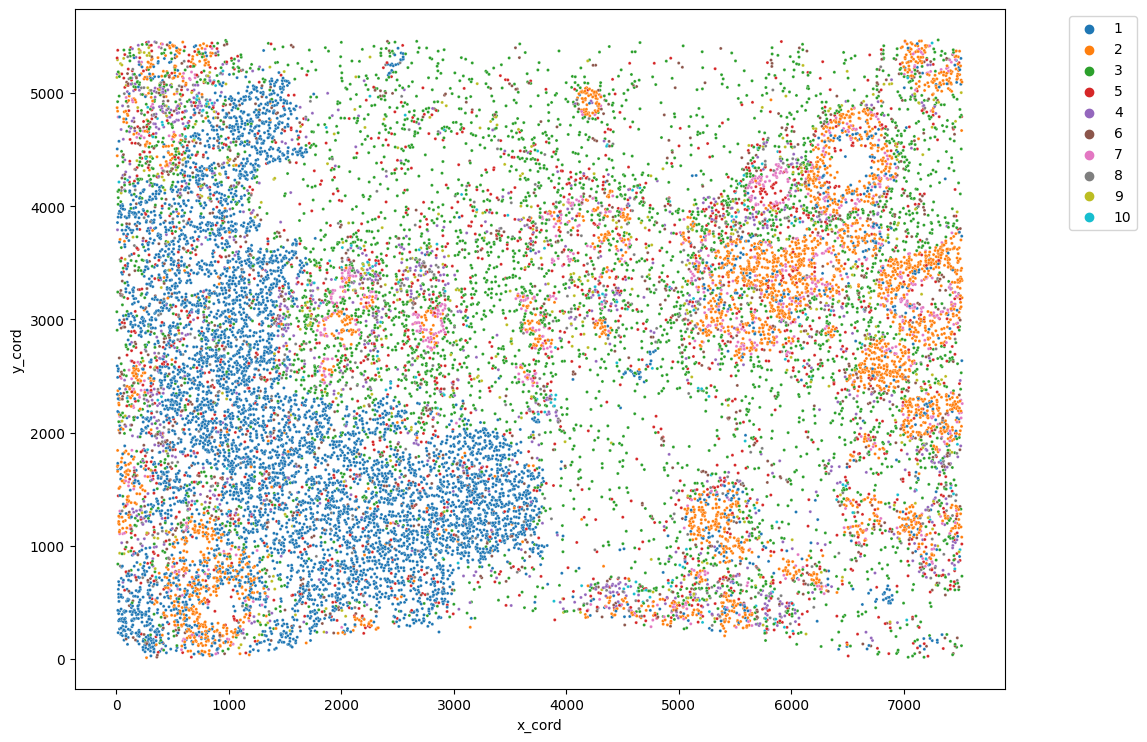

In [82]:
figure(figsize=(12, 9), dpi=100)

sns.scatterplot(data=datatest_clust2.obs, x='x_cord', y='y_cord', hue='pred_layer',  hue_order=order, s=5)
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))


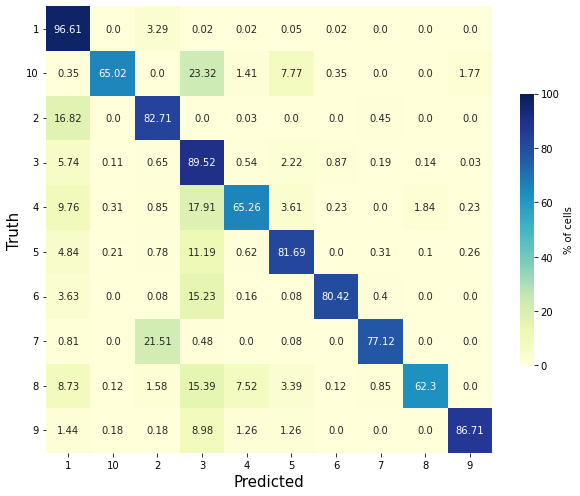

In [74]:
import seaborn as sns
contigency = pd.crosstab(datatest_clust2.obs['clusters'], type_pred_final)

for i in range(contigency.shape[0]):
    contigency.iloc[i,:] = contigency.iloc[i,:]/np.sum(contigency, axis=1)[i] * 100

fig = plt.figure(num=None, figsize=(10, 10), facecolor='w', edgecolor='k')

plt.clf()

ax = fig.add_subplot(111)

ax.set_aspect(1)

annot_m = np.empty(contigency.shape,dtype='<U16')
for i in range(contigency.shape[0]):
    for j in range(contigency.shape[0]):
        annot_m[i,j] = np.round(contigency.iloc[i,j], 2)

res = sns.heatmap(contigency, annot=annot_m, fmt="", cmap="YlGnBu", vmin=0.0, vmax=100, cbar_kws={'label': '% of cells', "shrink": 0.5}).set(ylabel="Truth", xlabel="Predicted")
cbar_axes = ax.figure.axes[-1]
ax.figure.axes[-1].yaxis.label.set_size(10)
# cbar = res.collections[0].colorbar
# cbar.set_label('Label for colour bar axis', labelpad=40)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Truth", fontsize=15)
# plt.title('How to plot a coningency table with python \n using matplotlib and seaborn ?',fontsize=12)

plt.xticks([i+0.5 for i in range(contigency.shape[0])], list(contigency.index))
plt.xticks(rotation=0)

plt.yticks([i+0.5 for i in range(contigency.shape[1])], list(contigency.index))
plt.yticks(rotation=0)

plt.yticks(rotation=0)

os.chdir("/Users/ameliaschroeder/Box/Amelia_Biostatistician/Celery/Output_Celery/Xenium_BreastCancer/Figures_Final/Domain")
plt.savefig('xenium_rep1_scheme2_spaOTsc_domain_contigency.png', dpi=100)

plt.show()

